# Estudo das métricas para avaliação dos filtros

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from scipy import signal
import h5py
import glob
import itertools


## Criacao de uma mascara gaussiana
def gkern(kernlen, std):
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d/np.sum(gkern2d)

## criando uma funcao de filtragem multidimensional
def linearFiltering(img,maskSize,filtType):
  mask            = np.zeros((maskSize,maskSize,1))
  if(filtType == 'gauss'):
    ## relacao W ~ 3*sigma
    sigma         = maskSize/3                                                   
    mask[:,:,0]   = gkern(maskSize,sigma)
    
  elif(filtType == 'mean'):
    ## criando uma mascara de media
    mask[:,:,0]   = (1/(maskSize**2))*np.ones((maskSize,maskSize))
  else:
    print("filter has not found")
    ## se nenhum filtro for escolhido convolui com um impulso
    mask[1,1,:]   = 1
  mask[:,:,0]     = np.rot90(np.rot90(mask[:,:,0]))  
  ## convolui com filtro rotacionado de 180 graus 
  return convolve(img,mask,mode = 'wrap')                                         

def calcErro(imgTruth,imgFiltered,metric = 'PSNR'):
  mse  = ((imgTruth-imgFiltered)**2).sum(axis=0).sum(axis=0)
  if(metric == 'PSNR'):
    return 20*np.log10(135-99 + 10) - 10*np.log10(mse)
  else:
    #print('Invalid metric, returning mse')
    return mse  

def matrix3Scale(image,flag):
  num = (image - image.min(axis=0).min(axis = 0))
  if(flag == 1):
    sup = 35      ## caso positivo considerar imagem truth
  else:
    sup = image.max(axis=0).max(axis = 0) ## caso negativo imagem real
  den = (sup - image.min(axis=0).min(axis = 0))
  return num/den
  

## Teste simples sobre o PSNR

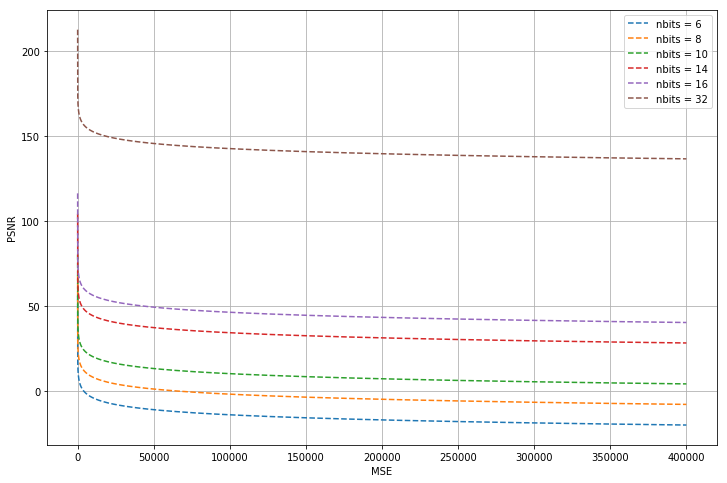

In [2]:
## Considerando uma imagem de 8bits
fig,ax = plt.subplots(1,1,figsize = (12,8))
nbits  = [6,8,10,14,16,32]
mse    = np.linspace(0.01,400000,10000)
for bits in nbits:
    ax.plot(mse,20*np.log10(2**bits - 1) - 10*np.log10(mse),'--',label = 'nbits = ' + str(bits))
ax.grid()
ax.set_xlabel('MSE')
#ax.set_xlim([0,0.1])
ax.set_ylabel('PSNR')
ax.legend()


In [3]:
folder = '../data/Runs001'

In [4]:
# lista com todos os arquivos .h5
fullFiles  = glob.glob(folder + '/*.h5')
fullFiles

['../data/Runs001/db_gen_2019-10-08Run_1000.h5']

In [5]:
## leitura dos arquivos de ruido
file_noise  = '../data/noise/noise_data.h5'
fn          = h5py.File(file_noise,'r')
ped         = fn['mean']
## run 817
ped         = ped[:,:,1]

In [6]:
## Leitura dos dados
## tamanho dos pacotes de imgs processados 
batch_size   = 32 
## limitantes superiores e inferiores
boundsup  = 135-99 + 10
boundinf  = 85 - 99 -10
## outputs
erro      = []
contraste = []
wvalue    = []
for filename in fullFiles:
  ## leitura do h5
  f          = h5py.File(filename,'r')
  ## matriz com imagens ruidosas
  objXtrain  = f['x_train']
  ## matriz com imagens truth correspondentes
  objYtrain  = f['y_train']
  ## vetor com intensidade correspondente
  objAlpha   = f['alpha']
  ## tamanho das matrizes #imagens x MxN
  size       = objXtrain.shape
  ## dimensao da imagem quadrada por default
  imdim      = int(np.sqrt(size[1]))
  ## adquirindo imagem pedestal centrada na origem
  p          = ped[1024-imdim//2:1024+imdim//2,1024-imdim//2:1024+imdim//2]
  ## vetores de varredura dos batches
  idx        = list(range(0,size[0],batch_size))
  idy        = list(range(batch_size,size[0],batch_size))
  idy.append(size[0])
  wrange     = range(1,3,2)
  ## leitura dos batches
  for w in wrange:
      for i,j in zip(idx,idy):
        ## reshaping para transformar batches de imagens em dim x dim x batch_size
        imReal   =  objXtrain[i:j,:].T.reshape(imdim,imdim,j-i)
        imTruth  =  objYtrain[i:j,:].T.reshape(imdim,imdim,j-i)
        alpha    =  objAlpha[i:j]
        ## normalizar pico para 1
        scale    = imTruth.max(axis = 0).max(axis=0)
        ## multiplica por alpha/pico -> alpha*I
        imTruth  = imTruth*(alpha/scale)
        ## replicando valor do ruido para subtrair
        multiPed = np.repeat(p[:, :, np.newaxis], imReal.shape[2], axis=2)
        ## removendo pedestal
        imNoPad = imReal-multiPed
        ## saturando imagem
        imNoPad[imNoPad>boundsup] = boundsup
        imNoPad[imNoPad<boundinf] = boundinf
        ## filtragem da imagem sem pedestal
        imFiltered = linearFiltering(imNoPad,w,'gauss')
        ## calculo do erro
        erro.append(calcErro(imTruth,imFiltered,'MSE'))
        ## armazenando contraste
        contraste.append(alpha)
        ## armazenando janelas
        wvalue.append([w]*(j-i))

## convertendo lista de listas em arrays 1D    
erro      = list(itertools.chain.from_iterable(erro))
contraste = list(itertools.chain.from_iterable(contraste))  
wvalue   = np.array(list(itertools.chain.from_iterable(wvalue)))   
## concatenando arrays 1D em 1 array 3D para analise
result  = np.array([contraste,erro,wvalue]).T

## Resultados do MSE na análise dos filtros

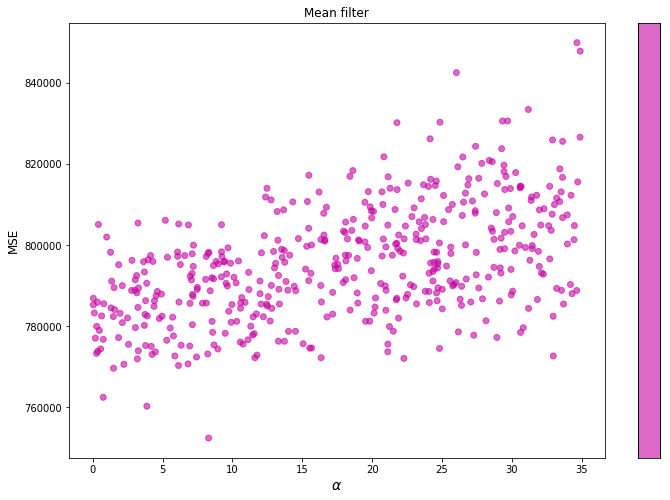

In [7]:
import matplotlib
fig = plt.figure(figsize=(12,8))
## filtragem nos dados por janela aux armazena indices
aux = result[np.where((result[:,2] < 33))]
x      = aux[:,0]
y      = aux[:,1]
label  = aux[:,2]
## selecionando cores para plot de forma randomica
np.random.seed(10)
colors = np.random.rand(len(np.unique(label)),3)
## scatter plots pelas cores de cada classe (w)
plt.scatter(x, y, c=label, alpha=0.6,cmap=matplotlib.colors.ListedColormap(colors))
## ajustes do plot e barra de exibicao
plt.xlabel(r'$\alpha$',fontsize = 14)
plt.ylabel('MSE',fontsize = 12)
plt.title('Mean filter')
cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc+1.25)
## criando labels na colorbar
ticklabels = []
for i in np.unique(label):
    ticklabels.append('window = ' + str(i))

cb.set_ticklabels(ticklabels)

### Comentários
Como esperado a aplicação do filtro apresenta significância no resultado até certo valor de janela.

### Deve-se entender:
Por que o resultado do MSE é invariante ao contraste?
### Como vou fazer?
- Comparar uma imagem de contraste muito bom e outra de contraste muito ruim
- Sem aplicação de filtros para facilitar o entendimento


## Análise da independência contraste x MSE

In [8]:
## imagens selecionadas do batch
idboa  = 6                             ## indice da imagem boa
idruim = 4                             ## indice da imagem ruim
## exibindo alphas correspondentes
print('alpha = '+ str(alpha[idboa]))
print('alpha = '+ str(alpha[idruim]))

alpha = 25.61918
alpha = 3.9543977


### imagens de forma visual

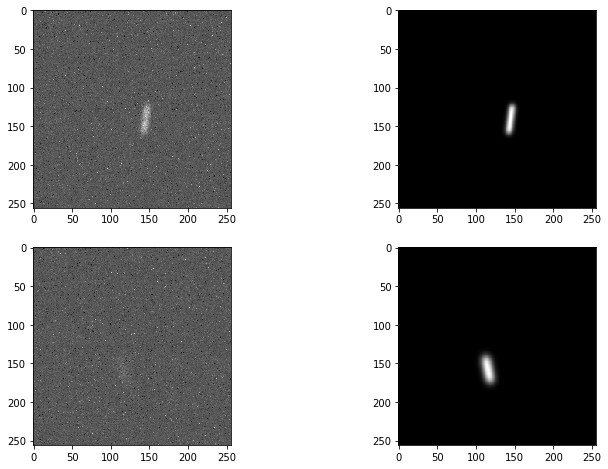

In [9]:
fig,ax = plt.subplots(2,2,figsize = (12,8))
ax[0,0].imshow(imNoPad[:,:,idboa],vmax = boundsup,vmin = boundinf,cmap = 'gray')
ax[0,1].imshow(imTruth[:,:,idboa],cmap = 'gray')
ax[1,0].imshow(imNoPad[:,:,idruim],vmax = boundsup,vmin = boundinf,cmap = 'gray')
ax[1,1].imshow(imTruth[:,:,idruim],cmap = 'gray')

In [10]:
### Olhando para o histograma de intensidades 

Text(0, 0.5, 'Log(counts)')

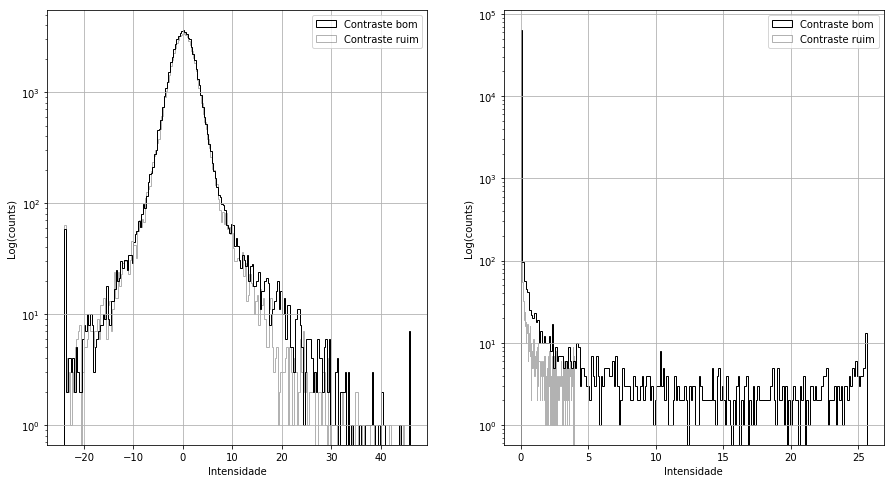

In [11]:
fig,ax = plt.subplots(1,2,figsize = (15,8))
x,y,z = ax[0].hist(imNoPad[:,:,idboa].ravel(),bins = 'scott',histtype='step',color = 'black',label = 'Contraste bom')
#ax[0].hist(imTruth[:,:,idboa].ravel(),bins = 'scott',histtype='step',color = 'black')
x,y,z = ax[0].hist(imNoPad[:,:,idruim].ravel(),bins = 'scott',histtype='step',color = 'black',alpha = 0.3,label = 'Contraste ruim')
#ax[1,1].hist(imTruth[:,:,idruim].ravel(),bins = 'scott',histtype='step',color = 'black')
ax[0].set_yscale('log')
ax[0].grid()
ax[0].legend()
ax[0].set_xlabel('Intensidade')
ax[0].set_ylabel('Log(counts)')

x,y,z = ax[1].hist(imTruth[:,:,idboa].ravel(),bins = 'scott',histtype='step',color = 'black',label = 'Contraste bom')
#ax[0].hist(imTruth[:,:,idboa].ravel(),bins = 'scott',histtype='step',color = 'black')
x,y,z = ax[1].hist(imTruth[:,:,idruim].ravel(),bins = 'scott',histtype='step',color = 'black',alpha = 0.3,label = 'Contraste ruim')
#ax[1,1].hist(imTruth[:,:,idruim].ravel(),bins = 'scott',histtype='step',color = 'black')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel('Intensidade')
ax[1].set_ylabel('Log(counts)')

 A minha resposta inicial é que a quantidade de eventos de background é muito maior que a quantidade de eventos de sinal fazendo com que a diferença no MSE seja imperceptível. Portanto a medida do PSNR não pode ser utilizada na nossa aplicação visto que ela da uma visão mais geral da melhoria das imagens e não tão local como precisamos
 
 Uma alternativa para essa medida pode ser o cálculo da energia do sinal em uma região =~ sigma ou 1.5 sigma e fazer a relação com a energia do ruído.

## Definindo região de sinal e background

In [12]:
nSigma = 0.5      ## quantos sigmas pegaremos do sinal
im_bin    = imTruth>alpha*(np.exp(-nSigma))   ## definindo com binaria a imagem maior que o threshold de 1 sigma

In [13]:
im_number = 4
## aquisicao da regiao de interesse
xv,yv = np.where((np.diff(im_bin[:,:,im_number],axis = 0) != 0))   ## detecta transicoes no eixo x
xh,yh = np.where((np.diff(im_bin[:,:,im_number],axis = 1) != 0))   ## detecta transicoes no eixo y
aux    = imTruth[:,:,im_number]
aux[xv,yv] = alpha[im_number]
aux[xh,yh] = alpha[im_number]


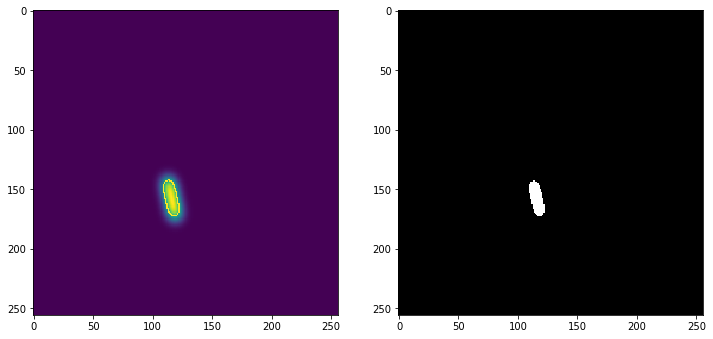

In [14]:
fig,ax = plt.subplots(1,2,figsize = (12,12))
ax[0].imshow(aux,cmap = 'viridis')
ax[1].imshow(im_bin[:,:,im_number],cmap = 'gray')